# Analisi California Housing

In [30]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from base_data_handler import BaseDataHandler
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## Caricamento e Preprocessing

In [31]:
# Caricamento dataset
housing = fetch_california_housing()
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['med_house_val'] = housing.target

# Creo l'handler e pulizia nomi
handler = BaseDataHandler(df=df)
_ = handler.try_clean_column_names()

# Rimozione outlier con percentili
mask = handler.get_outliers_df(upper_percentile=0.9, lower_percentile=0.09, method='percentile')
handler.df = handler.df[~mask]
handler.df.dropna(inplace=True)

print(f"\nDopo rimozione outlier: {len(handler.df)} righe (-{len(df) - len(handler.df)} outlier)")



Dopo rimozione outlier: 4727 righe (-15913 outlier)


## Feature Engineering

In [32]:
# Feature 1: Densità popolazione per area geografica
def add_population_per_cell(df, lat_col="latitude", lon_col="longitude", pop_col="population",
                            lat_bin=0.1, lon_bin=0.1):
    df = df.copy()
    df["_lat_bin"] = (df[lat_col] // lat_bin) * lat_bin
    df["_lon_bin"] = (df[lon_col] // lon_bin) * lon_bin
    
    pop_map = (
        df.groupby(["_lat_bin", "_lon_bin"])[pop_col]
        .sum()
        .reset_index()
        .rename(columns={pop_col: "pop_per_cell"})
    )
    
    df = df.merge(pop_map, on=["_lat_bin", "_lon_bin"], how="left")
    return df.drop(columns=["_lat_bin", "_lon_bin"])

handler.df = add_population_per_cell(handler.df)

# Feature 2: Classificazione geografica (coast/valley/inland)
_LAT = np.array([41.8, 39.0, 37.7, 36.6, 34.4, 34.0, 32.7])
_LON = np.array([-124.2, -123.7, -122.5, -121.9, -120.3, -118.5, -117.2])
_COAST_COEFFS = np.polyfit(_LAT, _LON, deg=2)

def _coast_lon(lat):
    a, b, c = _COAST_COEFFS
    return a*lat*lat + b*lat + c

def classify_location(lat, lon):
    coast_at_lat = _coast_lon(lat)
    coast_buffer = 1
    inland_shift = 2.3
    inland_at_lat = coast_at_lat + inland_shift
    
    if lon <= coast_at_lat + coast_buffer:
        return 2  # coast
    elif lon >= inland_at_lat:
        return 0  # inland
    else:
        return 1  # valley

_ = handler.try_add_col(target_col="position", func=lambda row: classify_location(row['latitude'], row['longitude']))



In [33]:
X = handler.df.drop(columns=["med_house_val", "medinc"])
y = handler.df["med_house_val"]

In [34]:
# Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [35]:
# Divisione train/test (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"Train set: {len(X_train)} campioni | Test set: {len(X_test)} campioni")


Train set: 3781 campioni | Test set: 946 campioni


## Training e valutazione dei modelli 

In [36]:
models = [
    ("Linear Regression", LinearRegression()),
    ("Random Forest", RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)),
    ("KNN Regressor", KNeighborsRegressor(n_neighbors=5)),
    ("XGBoost", XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42))
]



Linear Regression:
  R² Score:  0.435
  RMSE:      0.532
  MAE:       0.411
  MSE:       0.283

Random Forest:
  R² Score:  0.745
  RMSE:      0.357
  MAE:       0.257
  MSE:       0.127

KNN Regressor:
  R² Score:  0.487
  RMSE:      0.507
  MAE:       0.389
  MSE:       0.257

XGBoost:
  R² Score:  0.770
  RMSE:      0.339
  MAE:       0.239
  MSE:       0.115


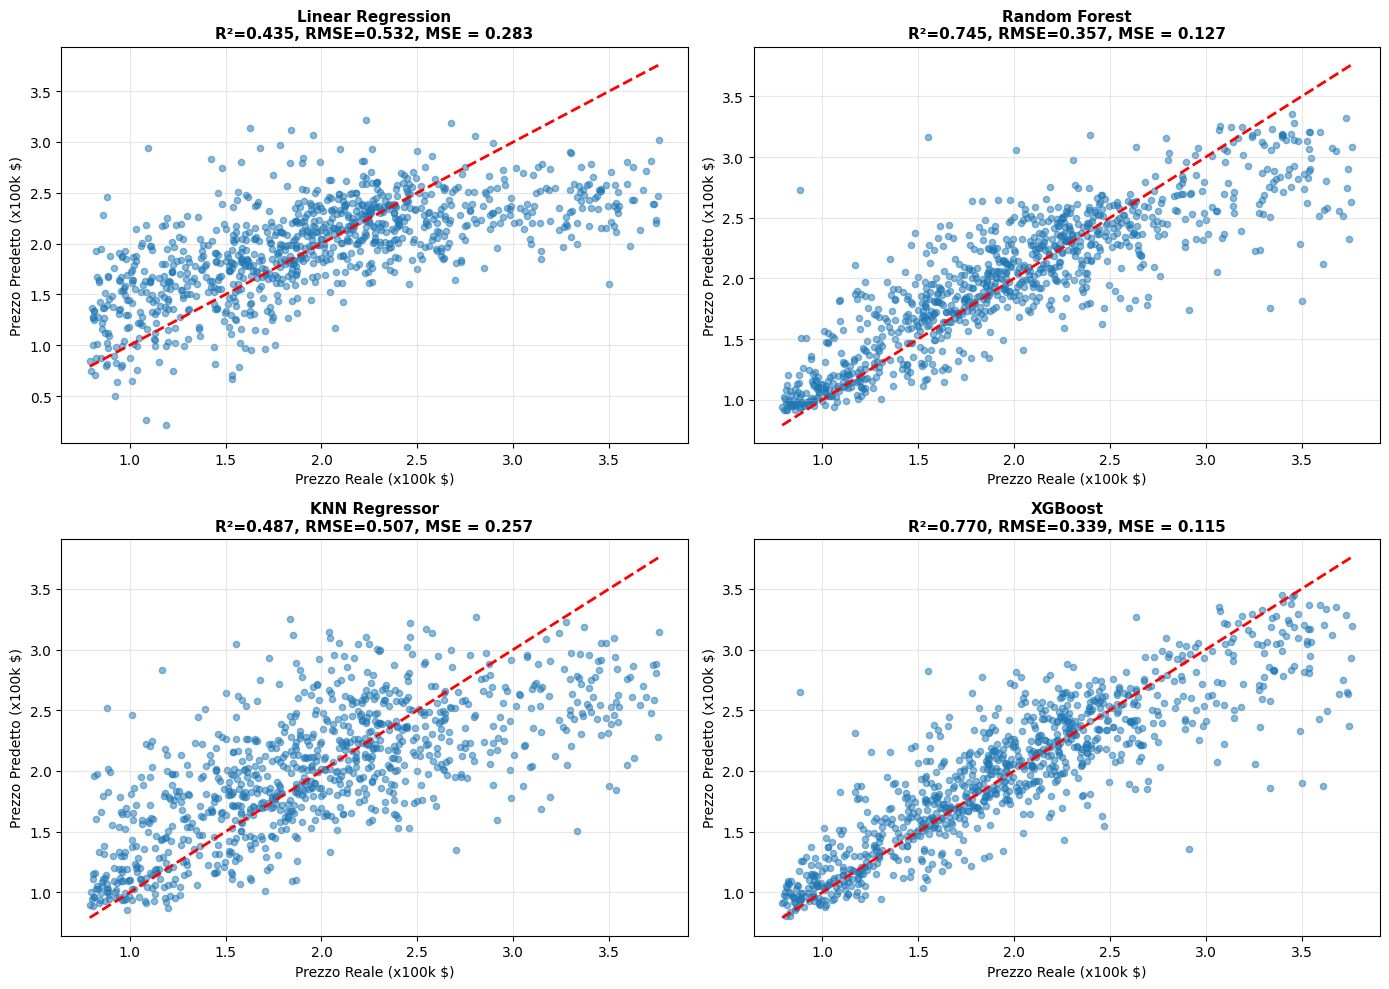

In [37]:
results = []

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (name, model) in enumerate(models):
    # Training
    model.fit(X_train, y_train)
    
    # Predizione
    y_pred = model.predict(X_test)
    
    # Metriche
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Salvo risultati
    results.append({
        'Modello': name,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse
    })
    
    # Stampo metriche
    print(f"\n{name}:")
    print(f"  R² Score:  {r2:.3f}")
    print(f"  RMSE:      {rmse:.3f}")
    print(f"  MAE:       {mae:.3f}")
    print(f"  MSE:       {mse:.3f}")
    
    # Visualizzazione
    ax = axes[idx]
    ax.scatter(y_test, y_pred, alpha=0.5, s=20)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax.set_xlabel("Prezzo Reale (x100k $)", fontsize=10)
    ax.set_ylabel("Prezzo Predetto (x100k $)", fontsize=10)
    ax.set_title(f"{name}\nR²={r2:.3f}, RMSE={rmse:.3f}, MSE = {mse:.3f}", fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Confronto 

In [38]:
results_df = pd.DataFrame(results).sort_values('R²', ascending=False)

print("\n" + "="*60)
print("CLASSIFICA MODELLI (ordinati per R²)")
print("="*60)
print(results_df.to_string(index=False))

# Identifica il miglior modello
best_model = results_df.iloc[0]['Modello']
best_r2 = results_df.iloc[0]['R²']

print(f"\n MIGLIOR MODELLO: {best_model} (R² = {best_r2:.3f})")
print(f"   → Spiega il {best_r2*100:.1f}% della varianza dei prezzi delle case")


CLASSIFICA MODELLI (ordinati per R²)
          Modello       R²     RMSE      MAE      MSE
          XGBoost 0.770045 0.339140 0.239298 0.115016
    Random Forest 0.745105 0.357058 0.256877 0.127490
    KNN Regressor 0.486860 0.506612 0.388992 0.256656
Linear Regression 0.434929 0.531630 0.410829 0.282630

 MIGLIOR MODELLO: XGBoost (R² = 0.770)
   → Spiega il 77.0% della varianza dei prezzi delle case


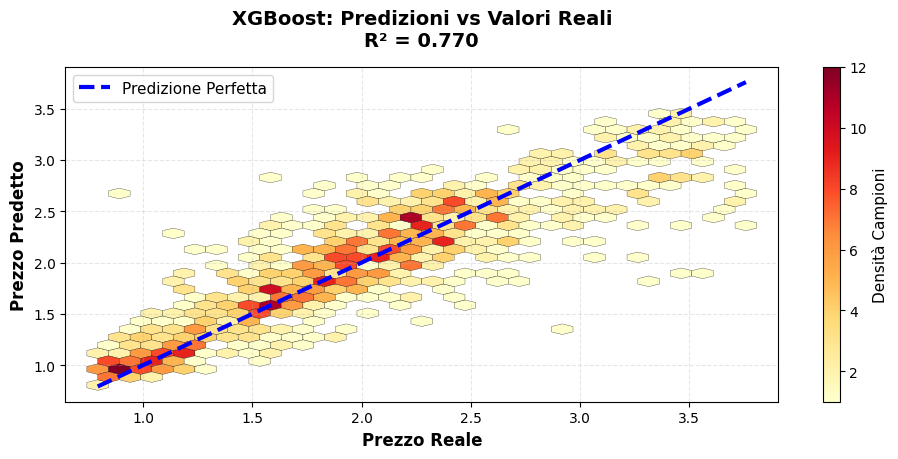

In [39]:
# Identifico il miglior modello e lo rialleno
best_model_name = results_df.iloc[0]['Modello']
best_model_obj = [m for n, m in models if n == best_model_name][0]
best_model_obj.fit(X_train, y_train)
y_pred_best = best_model_obj.predict(X_test)

# Calcolo i residui
residuals = y_test - y_pred_best

# Creo il dataset per l'analisi
analysis_df = pd.DataFrame({
    'true': y_test.values,
    'pred': y_pred_best,
    'residual': residuals.values,
    'abs_error': np.abs(residuals.values)
})


fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. Scatter con densità (hexbin) - Predizioni vs Reali
ax1 = fig.add_subplot(gs[0, :2])
hb = ax1.hexbin(y_test, y_pred_best, gridsize=30, cmap='YlOrRd', mincnt=1, edgecolors='black', linewidths=0.2)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b--', lw=3, label='Predizione Perfetta')
cb = plt.colorbar(hb, ax=ax1)
cb.set_label('Densità Campioni', fontsize=11)
ax1.set_xlabel('Prezzo Reale', fontsize=12, fontweight='bold')
ax1.set_ylabel('Prezzo Predetto', fontsize=12, fontweight='bold')
ax1.set_title(f'{best_model_name}: Predizioni vs Valori Reali\nR² = {results_df.iloc[0]["R²"]:.3f}', 
              fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=11, loc='upper left')
ax1.grid(alpha=0.3, linestyle='--')